New version of reconstruction script.

With tip loss of the original frame, without contour loss of the original frame.

With motion model loss (tip loss only). 

In [8]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion_tensor import CatheterMotion

# from mpl_toolkits.mplot3d import Axes3D


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list.to(gpu_or_cpu)
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        catheterMotion = CatheterMotion(self.p_start, self.gpu_or_cpu, l=0.2, r=0.01)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, self.para_init)
        # print("predicted_paras.requires_grad:", predicted_paras.requires_grad)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, predicted_paras[i].to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            
            # loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            # weight_m = torch.tensor([1.0, 1.0]).to(self.gpu_or_cpu)
            # loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            # motion_model_loss += loss_m.to(self.gpu_or_cpu)
            motion_model_loss += loss_tip_distance_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0, 1.0, 1.0]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        # loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        # print("-----------------------------------------------------------------")
        # print("loss_contour: ", loss_contour)
        # # print("loss_tip: ", loss_tip)
        # # print("loss_boundary: ", loss_boundary)
        # print("loss_tip_distance: ", loss_tip_distance)
        # # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        # print("motion_model_loss: ", motion_model_loss)
        # print("loss: ", loss)
        # print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [9]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [10]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [11]:

if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01 -2.39781477e-01  9.49010349e-01]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    
    # para_init = np.array([0.034, -0.003, 0.526, 0.13, -0.24, 0.6],
    #                  dtype=np.float32) #1
    para_init = np.array([0.034, -0.01, 0.536, 0.2, -0.37, 0.6],
                     dtype=np.float32)

    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = read_gt_params(cc_specs_path)
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/'
    image_save_path_list = [
    folder_path + 'gt_5_0.0006_-0.0008_0.2_0.01.png',
    folder_path + 'gt_4_0.0006_-0.0006_0.2_0.01.png',
    folder_path + 'gt_3_0.0006_-0.0004_0.2_0.01.png',
    folder_path + 'gt_2_0.0006_-0.0002_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    # delta_u_list = [[0, -0.0002], [0, -0.0002], [0, -0.0002], [0, -0.0002]]
    delta_u_list = torch.tensor([[0, -0.0002], [0, -0.0002], [0, -0.0002], [0, -0.0002]])

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 500
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_new3/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        # print("Gradients BEFORE BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
        #     else:
        #         print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        # print("Gradients AFTER BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
        #     else:
        #         print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        # for name, param in catheter_optimize_model.named_parameters():
        #     print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        # print("Loss: ", loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    for name, param in catheter_optimize_model.named_parameters():
        param_numpy = param.data.cpu().numpy()
        filename = f"{name}.npy"
        np.save(filename, param_numpy)
        print(f"Saved {name} to {filename}")

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/500 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   0%|          | 1/500 [00:01<12:34,  1.51s/it, loss=3.2e+6]


loop_id:  1


Optimizing:   0%|          | 2/500 [00:03<12:46,  1.54s/it, loss=2.02e+6]


loop_id:  2


Optimizing:   1%|          | 3/500 [00:04<12:56,  1.56s/it, loss=1.41e+6]


loop_id:  3


Optimizing:   1%|          | 4/500 [00:06<12:49,  1.55s/it, loss=1.06e+6]


loop_id:  4


Optimizing:   1%|          | 5/500 [00:08<14:14,  1.73s/it, loss=8.36e+5]


loop_id:  5


Optimizing:   1%|          | 6/500 [00:09<13:47,  1.68s/it, loss=6.76e+5]


loop_id:  6


Optimizing:   1%|▏         | 7/500 [00:11<13:35,  1.66s/it, loss=5.57e+5]


loop_id:  7


Optimizing:   2%|▏         | 8/500 [00:12<13:20,  1.63s/it, loss=4.65e+5]


loop_id:  8


Optimizing:   2%|▏         | 9/500 [00:14<13:45,  1.68s/it, loss=3.91e+5]


loop_id:  9


Optimizing:   2%|▏         | 10/500 [00:16<13:20,  1.63s/it, loss=3.31e+5]


loop_id:  10


Optimizing:   2%|▏         | 11/500 [00:17<13:12,  1.62s/it, loss=2.82e+5]


loop_id:  11


Optimizing:   2%|▏         | 12/500 [00:19<13:01,  1.60s/it, loss=2.41e+5]


loop_id:  12


Optimizing:   3%|▎         | 13/500 [00:21<13:01,  1.60s/it, loss=2.07e+5]


loop_id:  13


Optimizing:   3%|▎         | 14/500 [00:22<13:12,  1.63s/it, loss=1.78e+5]


loop_id:  14


Optimizing:   3%|▎         | 15/500 [00:24<13:04,  1.62s/it, loss=1.55e+5]


loop_id:  15


Optimizing:   3%|▎         | 16/500 [00:25<12:58,  1.61s/it, loss=1.35e+5]


loop_id:  16


Optimizing:   3%|▎         | 17/500 [00:27<12:52,  1.60s/it, loss=1.2e+5] 


loop_id:  17


Optimizing:   4%|▎         | 18/500 [00:29<12:36,  1.57s/it, loss=1.07e+5]


loop_id:  18


Optimizing:   4%|▍         | 19/500 [00:30<13:02,  1.63s/it, loss=9.78e+4]


loop_id:  19


Optimizing:   4%|▍         | 20/500 [00:32<12:51,  1.61s/it, loss=9.1e+4] 


loop_id:  20


Optimizing:   4%|▍         | 21/500 [00:33<12:43,  1.59s/it, loss=8.65e+4]


loop_id:  21


Optimizing:   4%|▍         | 22/500 [00:35<12:29,  1.57s/it, loss=8.39e+4]


loop_id:  22


Optimizing:   5%|▍         | 23/500 [00:36<12:29,  1.57s/it, loss=8.29e+4]


loop_id:  23


Optimizing:   5%|▍         | 24/500 [00:38<12:18,  1.55s/it, loss=8.32e+4]


loop_id:  24


Optimizing:   5%|▌         | 25/500 [00:40<12:38,  1.60s/it, loss=8.45e+4]


loop_id:  25


Optimizing:   5%|▌         | 26/500 [00:41<12:31,  1.59s/it, loss=8.65e+4]


loop_id:  26


Optimizing:   5%|▌         | 27/500 [00:43<12:20,  1.57s/it, loss=8.88e+4]


loop_id:  27


Optimizing:   6%|▌         | 28/500 [00:44<12:07,  1.54s/it, loss=9.12e+4]


loop_id:  28


Optimizing:   6%|▌         | 29/500 [00:46<12:03,  1.54s/it, loss=9.35e+4]


loop_id:  29


Optimizing:   6%|▌         | 30/500 [00:47<11:58,  1.53s/it, loss=9.54e+4]


loop_id:  30


Optimizing:   6%|▌         | 31/500 [00:49<12:28,  1.59s/it, loss=9.68e+4]


loop_id:  31


Optimizing:   6%|▋         | 32/500 [00:51<12:18,  1.58s/it, loss=9.76e+4]


loop_id:  32


Optimizing:   7%|▋         | 33/500 [00:52<12:13,  1.57s/it, loss=9.77e+4]


loop_id:  33


Optimizing:   7%|▋         | 34/500 [00:54<12:04,  1.56s/it, loss=9.72e+4]


loop_id:  34


Optimizing:   7%|▋         | 35/500 [00:55<11:58,  1.55s/it, loss=9.61e+4]


loop_id:  35


Optimizing:   7%|▋         | 36/500 [00:57<11:56,  1.54s/it, loss=9.45e+4]


loop_id:  36


Optimizing:   7%|▋         | 37/500 [00:58<12:17,  1.59s/it, loss=9.26e+4]


loop_id:  37


Optimizing:   8%|▊         | 38/500 [01:00<12:05,  1.57s/it, loss=9.04e+4]


loop_id:  38


Optimizing:   8%|▊         | 39/500 [01:01<11:57,  1.56s/it, loss=8.81e+4]


loop_id:  39


Optimizing:   8%|▊         | 40/500 [01:03<11:56,  1.56s/it, loss=8.59e+4]


loop_id:  40


Optimizing:   8%|▊         | 41/500 [01:05<11:49,  1.55s/it, loss=8.38e+4]


loop_id:  41


Optimizing:   8%|▊         | 42/500 [01:06<11:47,  1.54s/it, loss=8.19e+4]


loop_id:  42


Optimizing:   9%|▊         | 43/500 [01:08<11:56,  1.57s/it, loss=8.03e+4]


loop_id:  43


Optimizing:   9%|▉         | 44/500 [01:09<11:52,  1.56s/it, loss=7.9e+4] 


loop_id:  44


Optimizing:   9%|▉         | 45/500 [01:11<12:12,  1.61s/it, loss=7.8e+4]


loop_id:  45


Optimizing:   9%|▉         | 46/500 [01:13<12:01,  1.59s/it, loss=7.73e+4]


loop_id:  46


Optimizing:   9%|▉         | 47/500 [01:14<12:01,  1.59s/it, loss=7.68e+4]


loop_id:  47


Optimizing:  10%|▉         | 48/500 [01:16<11:58,  1.59s/it, loss=7.66e+4]


loop_id:  48


Optimizing:  10%|▉         | 49/500 [01:17<12:00,  1.60s/it, loss=7.64e+4]


loop_id:  49


Optimizing:  10%|█         | 50/500 [01:19<11:53,  1.58s/it, loss=7.63e+4]


loop_id:  50


Optimizing:  10%|█         | 51/500 [01:20<11:42,  1.56s/it, loss=7.62e+4]


loop_id:  51


Optimizing:  10%|█         | 52/500 [01:22<11:30,  1.54s/it, loss=7.6e+4] 


loop_id:  52


Optimizing:  11%|█         | 53/500 [01:24<12:01,  1.62s/it, loss=7.57e+4]


loop_id:  53


Optimizing:  11%|█         | 54/500 [01:25<11:49,  1.59s/it, loss=7.54e+4]


loop_id:  54


Optimizing:  11%|█         | 55/500 [01:27<11:47,  1.59s/it, loss=7.49e+4]


loop_id:  55


Optimizing:  11%|█         | 56/500 [01:28<11:35,  1.57s/it, loss=7.43e+4]


loop_id:  56


Optimizing:  11%|█▏        | 57/500 [01:30<11:34,  1.57s/it, loss=7.37e+4]


loop_id:  57


Optimizing:  12%|█▏        | 58/500 [01:31<11:29,  1.56s/it, loss=7.3e+4] 


loop_id:  58


Optimizing:  12%|█▏        | 59/500 [01:33<11:18,  1.54s/it, loss=7.22e+4]


loop_id:  59


Optimizing:  12%|█▏        | 60/500 [01:34<11:19,  1.55s/it, loss=7.14e+4]


loop_id:  60


Optimizing:  12%|█▏        | 61/500 [01:36<11:22,  1.56s/it, loss=7.07e+4]


loop_id:  61


Optimizing:  12%|█▏        | 62/500 [01:38<11:49,  1.62s/it, loss=6.99e+4]


loop_id:  62


Optimizing:  13%|█▎        | 63/500 [01:39<11:33,  1.59s/it, loss=6.92e+4]


loop_id:  63


Optimizing:  13%|█▎        | 64/500 [01:41<11:20,  1.56s/it, loss=6.86e+4]


loop_id:  64


Optimizing:  13%|█▎        | 65/500 [01:42<11:19,  1.56s/it, loss=6.8e+4] 


loop_id:  65


Optimizing:  13%|█▎        | 66/500 [01:44<11:20,  1.57s/it, loss=6.74e+4]


loop_id:  66


Optimizing:  13%|█▎        | 67/500 [01:46<11:17,  1.57s/it, loss=6.69e+4]


loop_id:  67


Optimizing:  14%|█▎        | 68/500 [01:47<11:55,  1.66s/it, loss=6.64e+4]


loop_id:  68


Optimizing:  14%|█▍        | 69/500 [01:49<11:38,  1.62s/it, loss=6.6e+4] 


loop_id:  69


Optimizing:  14%|█▍        | 70/500 [01:50<11:22,  1.59s/it, loss=6.55e+4]


loop_id:  70


Optimizing:  14%|█▍        | 71/500 [01:52<11:14,  1.57s/it, loss=6.5e+4] 


loop_id:  71


Optimizing:  14%|█▍        | 72/500 [01:54<11:37,  1.63s/it, loss=6.45e+4]


loop_id:  72


Optimizing:  15%|█▍        | 73/500 [01:55<11:21,  1.60s/it, loss=6.41e+4]


loop_id:  73


Optimizing:  15%|█▍        | 74/500 [01:57<11:18,  1.59s/it, loss=6.36e+4]


loop_id:  74


Optimizing:  15%|█▌        | 75/500 [01:58<11:16,  1.59s/it, loss=6.3e+4] 


loop_id:  75


Optimizing:  15%|█▌        | 76/500 [02:00<11:06,  1.57s/it, loss=6.25e+4]


loop_id:  76


Optimizing:  15%|█▌        | 77/500 [02:02<11:14,  1.59s/it, loss=6.2e+4] 


loop_id:  77


Optimizing:  16%|█▌        | 78/500 [02:03<11:07,  1.58s/it, loss=6.14e+4]


loop_id:  78


Optimizing:  16%|█▌        | 79/500 [02:05<11:07,  1.59s/it, loss=6.09e+4]


loop_id:  79


Optimizing:  16%|█▌        | 80/500 [02:06<11:10,  1.60s/it, loss=6.03e+4]


loop_id:  80


Optimizing:  16%|█▌        | 81/500 [02:08<11:17,  1.62s/it, loss=5.98e+4]


loop_id:  81


Optimizing:  16%|█▋        | 82/500 [02:10<11:01,  1.58s/it, loss=5.92e+4]


loop_id:  82


Optimizing:  17%|█▋        | 83/500 [02:11<11:38,  1.67s/it, loss=5.87e+4]


loop_id:  83


Optimizing:  17%|█▋        | 84/500 [02:13<11:22,  1.64s/it, loss=5.82e+4]


loop_id:  84


Optimizing:  17%|█▋        | 85/500 [02:15<11:14,  1.63s/it, loss=5.77e+4]


loop_id:  85


Optimizing:  17%|█▋        | 86/500 [02:16<10:59,  1.59s/it, loss=5.72e+4]


loop_id:  86


Optimizing:  17%|█▋        | 87/500 [02:18<11:01,  1.60s/it, loss=5.66e+4]


loop_id:  87


Optimizing:  18%|█▊        | 88/500 [02:19<10:54,  1.59s/it, loss=5.61e+4]


loop_id:  88


Optimizing:  18%|█▊        | 89/500 [02:21<11:03,  1.62s/it, loss=5.57e+4]


loop_id:  89


Optimizing:  18%|█▊        | 90/500 [02:23<10:56,  1.60s/it, loss=5.52e+4]


loop_id:  90


Optimizing:  18%|█▊        | 91/500 [02:24<11:01,  1.62s/it, loss=5.47e+4]


loop_id:  91


Optimizing:  18%|█▊        | 92/500 [02:26<10:49,  1.59s/it, loss=5.42e+4]


loop_id:  92


Optimizing:  19%|█▊        | 93/500 [02:27<10:49,  1.59s/it, loss=5.37e+4]


loop_id:  93


Optimizing:  19%|█▉        | 94/500 [02:29<11:19,  1.67s/it, loss=5.32e+4]


loop_id:  94


Optimizing:  19%|█▉        | 95/500 [02:31<11:18,  1.68s/it, loss=5.27e+4]


loop_id:  95


Optimizing:  19%|█▉        | 96/500 [02:32<10:58,  1.63s/it, loss=5.22e+4]


loop_id:  96


Optimizing:  19%|█▉        | 97/500 [02:34<10:49,  1.61s/it, loss=5.17e+4]


loop_id:  97


Optimizing:  20%|█▉        | 98/500 [02:36<10:52,  1.62s/it, loss=5.12e+4]


loop_id:  98


Optimizing:  20%|█▉        | 99/500 [02:37<10:48,  1.62s/it, loss=5.07e+4]


loop_id:  99


Optimizing:  20%|██        | 100/500 [02:39<10:33,  1.58s/it, loss=5.02e+4]


loop_id:  100


Optimizing:  20%|██        | 101/500 [02:40<10:51,  1.63s/it, loss=4.97e+4]


loop_id:  101


Optimizing:  20%|██        | 102/500 [02:42<10:40,  1.61s/it, loss=4.92e+4]


loop_id:  102


Optimizing:  21%|██        | 103/500 [02:44<10:34,  1.60s/it, loss=4.87e+4]


loop_id:  103


Optimizing:  21%|██        | 104/500 [02:45<10:32,  1.60s/it, loss=4.82e+4]


loop_id:  104


Optimizing:  21%|██        | 105/500 [02:47<10:33,  1.60s/it, loss=4.77e+4]


loop_id:  105


Optimizing:  21%|██        | 106/500 [02:48<10:23,  1.58s/it, loss=4.72e+4]


loop_id:  106


Optimizing:  21%|██▏       | 107/500 [02:50<10:24,  1.59s/it, loss=4.67e+4]


loop_id:  107


Optimizing:  22%|██▏       | 108/500 [02:52<11:04,  1.69s/it, loss=4.62e+4]


loop_id:  108


Optimizing:  22%|██▏       | 109/500 [02:54<10:58,  1.68s/it, loss=4.57e+4]


loop_id:  109


Optimizing:  22%|██▏       | 110/500 [02:55<10:38,  1.64s/it, loss=4.52e+4]


loop_id:  110


Optimizing:  22%|██▏       | 111/500 [02:57<10:46,  1.66s/it, loss=4.47e+4]


loop_id:  111


Optimizing:  22%|██▏       | 112/500 [02:58<10:37,  1.64s/it, loss=4.43e+4]


loop_id:  112


Optimizing:  23%|██▎       | 113/500 [03:00<10:37,  1.65s/it, loss=4.38e+4]


loop_id:  113


Optimizing:  23%|██▎       | 114/500 [03:02<10:27,  1.63s/it, loss=4.33e+4]


loop_id:  114


Optimizing:  23%|██▎       | 115/500 [03:03<10:32,  1.64s/it, loss=4.28e+4]


loop_id:  115


Optimizing:  23%|██▎       | 116/500 [03:05<10:16,  1.61s/it, loss=4.23e+4]


loop_id:  116


Optimizing:  23%|██▎       | 117/500 [03:07<10:25,  1.63s/it, loss=4.18e+4]


loop_id:  117


Optimizing:  24%|██▎       | 118/500 [03:08<10:19,  1.62s/it, loss=4.13e+4]


loop_id:  118


Optimizing:  24%|██▍       | 119/500 [03:10<10:21,  1.63s/it, loss=4.09e+4]


loop_id:  119


Optimizing:  24%|██▍       | 120/500 [03:11<10:09,  1.60s/it, loss=4.04e+4]


loop_id:  120


Optimizing:  24%|██▍       | 121/500 [03:13<10:21,  1.64s/it, loss=3.99e+4]


loop_id:  121


Optimizing:  24%|██▍       | 122/500 [03:15<10:15,  1.63s/it, loss=3.94e+4]


loop_id:  122


Optimizing:  25%|██▍       | 123/500 [03:17<11:02,  1.76s/it, loss=3.89e+4]


loop_id:  123


Optimizing:  25%|██▍       | 124/500 [03:18<10:42,  1.71s/it, loss=3.85e+4]


loop_id:  124


Optimizing:  25%|██▌       | 125/500 [03:20<10:40,  1.71s/it, loss=3.8e+4] 


loop_id:  125


Optimizing:  25%|██▌       | 126/500 [03:22<10:21,  1.66s/it, loss=3.75e+4]


loop_id:  126


Optimizing:  25%|██▌       | 127/500 [03:23<10:27,  1.68s/it, loss=3.7e+4] 


loop_id:  127


Optimizing:  26%|██▌       | 128/500 [03:25<10:13,  1.65s/it, loss=3.66e+4]


loop_id:  128


Optimizing:  26%|██▌       | 129/500 [03:27<10:23,  1.68s/it, loss=3.61e+4]


loop_id:  129


Optimizing:  26%|██▌       | 130/500 [03:28<10:18,  1.67s/it, loss=3.56e+4]


loop_id:  130


Optimizing:  26%|██▌       | 131/500 [03:30<10:26,  1.70s/it, loss=3.52e+4]


loop_id:  131


Optimizing:  26%|██▋       | 132/500 [03:32<10:12,  1.66s/it, loss=3.47e+4]


loop_id:  132


Optimizing:  27%|██▋       | 133/500 [03:33<10:21,  1.69s/it, loss=3.42e+4]


loop_id:  133


Optimizing:  27%|██▋       | 134/500 [03:35<10:10,  1.67s/it, loss=3.38e+4]


loop_id:  134


Optimizing:  27%|██▋       | 135/500 [03:37<10:10,  1.67s/it, loss=3.33e+4]


loop_id:  135


Optimizing:  27%|██▋       | 136/500 [03:38<10:03,  1.66s/it, loss=3.28e+4]


loop_id:  136


Optimizing:  27%|██▋       | 137/500 [03:40<10:06,  1.67s/it, loss=3.24e+4]


loop_id:  137


Optimizing:  28%|██▊       | 138/500 [03:42<10:40,  1.77s/it, loss=3.19e+4]


loop_id:  138


Optimizing:  28%|██▊       | 139/500 [03:44<10:27,  1.74s/it, loss=3.15e+4]


loop_id:  139


Optimizing:  28%|██▊       | 140/500 [03:45<10:17,  1.72s/it, loss=3.1e+4] 


loop_id:  140


Optimizing:  28%|██▊       | 141/500 [03:47<10:03,  1.68s/it, loss=3.05e+4]


loop_id:  141


Optimizing:  28%|██▊       | 142/500 [03:49<09:55,  1.66s/it, loss=3.01e+4]


loop_id:  142


Optimizing:  29%|██▊       | 143/500 [03:50<09:52,  1.66s/it, loss=2.97e+4]


loop_id:  143


Optimizing:  29%|██▉       | 144/500 [03:52<09:44,  1.64s/it, loss=2.92e+4]


loop_id:  144


Optimizing:  29%|██▉       | 145/500 [03:53<09:38,  1.63s/it, loss=2.88e+4]


loop_id:  145


Optimizing:  29%|██▉       | 146/500 [03:55<09:42,  1.65s/it, loss=2.83e+4]


loop_id:  146


Optimizing:  29%|██▉       | 147/500 [03:57<09:37,  1.64s/it, loss=2.79e+4]


loop_id:  147


Optimizing:  30%|██▉       | 148/500 [03:58<09:36,  1.64s/it, loss=2.75e+4]


loop_id:  148


Optimizing:  30%|██▉       | 149/500 [04:00<09:36,  1.64s/it, loss=2.71e+4]


loop_id:  149


Optimizing:  30%|███       | 150/500 [04:02<09:47,  1.68s/it, loss=2.67e+4]


loop_id:  150


Optimizing:  30%|███       | 151/500 [04:04<10:14,  1.76s/it, loss=2.62e+4]


loop_id:  151


Optimizing:  30%|███       | 152/500 [04:06<10:32,  1.82s/it, loss=2.58e+4]


loop_id:  152


Optimizing:  31%|███       | 153/500 [04:07<10:14,  1.77s/it, loss=2.54e+4]


loop_id:  153


Optimizing:  31%|███       | 154/500 [04:09<10:16,  1.78s/it, loss=2.5e+4] 


loop_id:  154


Optimizing:  31%|███       | 155/500 [04:11<10:15,  1.78s/it, loss=2.46e+4]


loop_id:  155


Optimizing:  31%|███       | 156/500 [04:13<10:16,  1.79s/it, loss=2.43e+4]


loop_id:  156


Optimizing:  31%|███▏      | 157/500 [04:15<10:57,  1.92s/it, loss=2.39e+4]


loop_id:  157


Optimizing:  32%|███▏      | 158/500 [04:17<10:34,  1.86s/it, loss=2.35e+4]


loop_id:  158


Optimizing:  32%|███▏      | 159/500 [04:18<10:23,  1.83s/it, loss=2.31e+4]


loop_id:  159


Optimizing:  32%|███▏      | 160/500 [04:20<10:07,  1.79s/it, loss=2.28e+4]


loop_id:  160


Optimizing:  32%|███▏      | 161/500 [04:22<09:51,  1.74s/it, loss=2.24e+4]


loop_id:  161


Optimizing:  32%|███▏      | 162/500 [04:23<09:41,  1.72s/it, loss=2.21e+4]


loop_id:  162


Optimizing:  33%|███▎      | 163/500 [04:25<09:34,  1.71s/it, loss=2.17e+4]


loop_id:  163


Optimizing:  33%|███▎      | 164/500 [04:27<09:32,  1.70s/it, loss=2.14e+4]


loop_id:  164


Optimizing:  33%|███▎      | 165/500 [04:29<09:40,  1.73s/it, loss=2.11e+4]


loop_id:  165


Optimizing:  33%|███▎      | 166/500 [04:30<09:23,  1.69s/it, loss=2.07e+4]


loop_id:  166


Optimizing:  33%|███▎      | 167/500 [04:32<09:21,  1.69s/it, loss=2.04e+4]


loop_id:  167


Optimizing:  34%|███▎      | 168/500 [04:33<09:14,  1.67s/it, loss=2.01e+4]


loop_id:  168


Optimizing:  34%|███▍      | 169/500 [04:35<09:16,  1.68s/it, loss=1.98e+4]


loop_id:  169


Optimizing:  34%|███▍      | 170/500 [04:37<09:16,  1.69s/it, loss=1.95e+4]


loop_id:  170


Optimizing:  34%|███▍      | 171/500 [04:39<09:31,  1.74s/it, loss=1.92e+4]


loop_id:  171


Optimizing:  34%|███▍      | 172/500 [04:40<09:22,  1.71s/it, loss=1.89e+4]


loop_id:  172


Optimizing:  35%|███▍      | 173/500 [04:42<09:14,  1.70s/it, loss=1.86e+4]


loop_id:  173


Optimizing:  35%|███▍      | 174/500 [04:44<09:09,  1.68s/it, loss=1.83e+4]


loop_id:  174


Optimizing:  35%|███▌      | 175/500 [04:45<09:02,  1.67s/it, loss=1.8e+4] 


loop_id:  175


Optimizing:  35%|███▌      | 176/500 [04:47<08:50,  1.64s/it, loss=1.77e+4]


loop_id:  176


Optimizing:  35%|███▌      | 177/500 [04:49<09:44,  1.81s/it, loss=1.74e+4]


loop_id:  177


Optimizing:  36%|███▌      | 178/500 [04:51<09:18,  1.73s/it, loss=1.71e+4]


loop_id:  178


Optimizing:  36%|███▌      | 179/500 [04:52<09:10,  1.71s/it, loss=1.69e+4]


loop_id:  179


Optimizing:  36%|███▌      | 180/500 [04:54<09:02,  1.70s/it, loss=1.66e+4]


loop_id:  180


Optimizing:  36%|███▌      | 181/500 [04:56<09:01,  1.70s/it, loss=1.63e+4]


loop_id:  181


Optimizing:  36%|███▋      | 182/500 [04:57<08:49,  1.67s/it, loss=1.61e+4]


loop_id:  182


Optimizing:  37%|███▋      | 183/500 [04:59<08:59,  1.70s/it, loss=1.58e+4]


loop_id:  183


Optimizing:  37%|███▋      | 184/500 [05:01<08:50,  1.68s/it, loss=1.55e+4]


loop_id:  184


Optimizing:  37%|███▋      | 185/500 [05:02<08:49,  1.68s/it, loss=1.53e+4]


loop_id:  185


Optimizing:  37%|███▋      | 186/500 [05:04<08:46,  1.68s/it, loss=1.5e+4] 


loop_id:  186


Optimizing:  37%|███▋      | 187/500 [05:06<08:43,  1.67s/it, loss=1.48e+4]


loop_id:  187


Optimizing:  38%|███▊      | 188/500 [05:07<08:34,  1.65s/it, loss=1.45e+4]


loop_id:  188


Optimizing:  38%|███▊      | 189/500 [05:09<08:38,  1.67s/it, loss=1.43e+4]


loop_id:  189


Optimizing:  38%|███▊      | 190/500 [05:11<08:34,  1.66s/it, loss=1.41e+4]


loop_id:  190


Optimizing:  38%|███▊      | 191/500 [05:12<08:33,  1.66s/it, loss=1.38e+4]


loop_id:  191


Optimizing:  38%|███▊      | 192/500 [05:14<08:33,  1.67s/it, loss=1.36e+4]


loop_id:  192


Optimizing:  39%|███▊      | 193/500 [05:16<08:35,  1.68s/it, loss=1.34e+4]


loop_id:  193


Optimizing:  39%|███▉      | 194/500 [05:17<08:30,  1.67s/it, loss=1.32e+4]


loop_id:  194


Optimizing:  39%|███▉      | 195/500 [05:19<08:31,  1.68s/it, loss=1.3e+4] 


loop_id:  195


Optimizing:  39%|███▉      | 196/500 [05:21<08:28,  1.67s/it, loss=1.27e+4]


loop_id:  196


Optimizing:  39%|███▉      | 197/500 [05:23<09:14,  1.83s/it, loss=1.25e+4]


loop_id:  197


Optimizing:  40%|███▉      | 198/500 [05:25<08:53,  1.77s/it, loss=1.23e+4]


loop_id:  198


Optimizing:  40%|███▉      | 199/500 [05:26<08:45,  1.75s/it, loss=1.21e+4]


loop_id:  199


Optimizing:  40%|████      | 200/500 [05:28<08:40,  1.73s/it, loss=1.19e+4]


loop_id:  200


Optimizing:  40%|████      | 201/500 [05:30<08:44,  1.76s/it, loss=1.17e+4]


loop_id:  201


Optimizing:  40%|████      | 202/500 [05:31<08:31,  1.72s/it, loss=1.15e+4]


loop_id:  202


Optimizing:  41%|████      | 203/500 [05:33<08:27,  1.71s/it, loss=1.13e+4]


loop_id:  203


Optimizing:  41%|████      | 204/500 [05:35<08:17,  1.68s/it, loss=1.12e+4]


loop_id:  204


Optimizing:  41%|████      | 205/500 [05:36<08:19,  1.69s/it, loss=1.1e+4] 


loop_id:  205


Optimizing:  41%|████      | 206/500 [05:38<08:10,  1.67s/it, loss=1.08e+4]


loop_id:  206


Optimizing:  41%|████▏     | 207/500 [05:40<08:09,  1.67s/it, loss=1.06e+4]


loop_id:  207


Optimizing:  42%|████▏     | 208/500 [05:41<08:07,  1.67s/it, loss=1.04e+4]


loop_id:  208


Optimizing:  42%|████▏     | 209/500 [05:43<08:07,  1.68s/it, loss=1.03e+4]


loop_id:  209


Optimizing:  42%|████▏     | 210/500 [05:45<08:02,  1.66s/it, loss=1.01e+4]


loop_id:  210


Optimizing:  42%|████▏     | 211/500 [05:46<08:04,  1.68s/it, loss=9.93e+3]


loop_id:  211


Optimizing:  42%|████▏     | 212/500 [05:48<07:59,  1.67s/it, loss=9.77e+3]


loop_id:  212


Optimizing:  43%|████▎     | 213/500 [05:50<08:01,  1.68s/it, loss=9.61e+3]


loop_id:  213


Optimizing:  43%|████▎     | 214/500 [05:51<07:53,  1.66s/it, loss=9.45e+3]


loop_id:  214


Optimizing:  43%|████▎     | 215/500 [05:53<07:55,  1.67s/it, loss=9.29e+3]


loop_id:  215


Optimizing:  43%|████▎     | 216/500 [05:55<07:53,  1.67s/it, loss=9.14e+3]


loop_id:  216


Optimizing:  43%|████▎     | 217/500 [05:56<07:57,  1.69s/it, loss=8.99e+3]


loop_id:  217


Optimizing:  44%|████▎     | 218/500 [05:58<07:50,  1.67s/it, loss=8.84e+3]


loop_id:  218


Optimizing:  44%|████▍     | 219/500 [06:00<07:56,  1.69s/it, loss=8.69e+3]


loop_id:  219


Optimizing:  44%|████▍     | 220/500 [06:01<07:47,  1.67s/it, loss=8.55e+3]


loop_id:  220


Optimizing:  44%|████▍     | 221/500 [06:03<07:52,  1.69s/it, loss=8.41e+3]


loop_id:  221


Optimizing:  44%|████▍     | 222/500 [06:05<07:45,  1.67s/it, loss=8.27e+3]


loop_id:  222


Optimizing:  45%|████▍     | 223/500 [06:07<08:30,  1.84s/it, loss=8.14e+3]


loop_id:  223


Optimizing:  45%|████▍     | 224/500 [06:09<08:14,  1.79s/it, loss=8e+3]   


loop_id:  224


Optimizing:  45%|████▌     | 225/500 [06:10<08:02,  1.75s/it, loss=7.87e+3]


loop_id:  225


Optimizing:  45%|████▌     | 226/500 [06:12<07:46,  1.70s/it, loss=7.74e+3]


loop_id:  226


Optimizing:  45%|████▌     | 227/500 [06:14<07:49,  1.72s/it, loss=7.61e+3]


loop_id:  227


Optimizing:  46%|████▌     | 228/500 [06:15<07:39,  1.69s/it, loss=7.49e+3]


loop_id:  228


Optimizing:  46%|████▌     | 229/500 [06:17<07:35,  1.68s/it, loss=7.37e+3]


loop_id:  229


Optimizing:  46%|████▌     | 230/500 [06:19<07:41,  1.71s/it, loss=7.25e+3]


loop_id:  230


Optimizing:  46%|████▌     | 231/500 [06:20<07:34,  1.69s/it, loss=7.13e+3]


loop_id:  231


Optimizing:  46%|████▋     | 232/500 [06:22<07:26,  1.67s/it, loss=7.01e+3]


loop_id:  232


Optimizing:  47%|████▋     | 233/500 [06:24<07:31,  1.69s/it, loss=6.89e+3]


loop_id:  233


Optimizing:  47%|████▋     | 234/500 [06:25<07:23,  1.67s/it, loss=6.78e+3]


loop_id:  234


Optimizing:  47%|████▋     | 235/500 [06:27<07:24,  1.68s/it, loss=6.67e+3]


loop_id:  235


Optimizing:  47%|████▋     | 236/500 [06:29<07:25,  1.69s/it, loss=6.56e+3]


loop_id:  236


Optimizing:  47%|████▋     | 237/500 [06:30<07:23,  1.69s/it, loss=6.45e+3]


loop_id:  237


Optimizing:  48%|████▊     | 238/500 [06:32<07:14,  1.66s/it, loss=6.35e+3]


loop_id:  238


Optimizing:  48%|████▊     | 239/500 [06:34<07:19,  1.68s/it, loss=6.24e+3]


loop_id:  239


Optimizing:  48%|████▊     | 240/500 [06:35<07:14,  1.67s/it, loss=6.14e+3]


loop_id:  240


Optimizing:  48%|████▊     | 241/500 [06:37<07:12,  1.67s/it, loss=6.04e+3]


loop_id:  241


Optimizing:  48%|████▊     | 242/500 [06:39<07:09,  1.66s/it, loss=5.94e+3]


loop_id:  242


Optimizing:  49%|████▊     | 243/500 [06:40<07:12,  1.68s/it, loss=5.85e+3]


loop_id:  243


Optimizing:  49%|████▉     | 244/500 [06:42<07:09,  1.68s/it, loss=5.75e+3]


loop_id:  244


Optimizing:  49%|████▉     | 245/500 [06:44<07:09,  1.69s/it, loss=5.66e+3]


loop_id:  245


Optimizing:  49%|████▉     | 246/500 [06:46<07:06,  1.68s/it, loss=5.57e+3]


loop_id:  246


Optimizing:  49%|████▉     | 247/500 [06:47<07:09,  1.70s/it, loss=5.47e+3]


loop_id:  247


Optimizing:  50%|████▉     | 248/500 [06:49<07:03,  1.68s/it, loss=5.39e+3]


loop_id:  248


Optimizing:  50%|████▉     | 249/500 [06:51<07:54,  1.89s/it, loss=5.3e+3] 


loop_id:  249


Optimizing:  50%|█████     | 250/500 [06:53<07:33,  1.81s/it, loss=5.21e+3]


loop_id:  250


Optimizing:  50%|█████     | 251/500 [06:55<07:20,  1.77s/it, loss=5.13e+3]


loop_id:  251


Optimizing:  50%|█████     | 252/500 [06:56<07:09,  1.73s/it, loss=5.04e+3]


loop_id:  252


Optimizing:  51%|█████     | 253/500 [06:58<07:01,  1.71s/it, loss=4.96e+3]


loop_id:  253


Optimizing:  51%|█████     | 254/500 [06:59<06:51,  1.67s/it, loss=4.88e+3]


loop_id:  254


Optimizing:  51%|█████     | 255/500 [07:01<06:58,  1.71s/it, loss=4.8e+3] 


loop_id:  255


Optimizing:  51%|█████     | 256/500 [07:03<06:52,  1.69s/it, loss=4.72e+3]


loop_id:  256


Optimizing:  51%|█████▏    | 257/500 [07:05<06:51,  1.69s/it, loss=4.65e+3]


loop_id:  257


Optimizing:  52%|█████▏    | 258/500 [07:06<06:49,  1.69s/it, loss=4.57e+3]


loop_id:  258


Optimizing:  52%|█████▏    | 259/500 [07:08<06:52,  1.71s/it, loss=4.5e+3] 


loop_id:  259


Optimizing:  52%|█████▏    | 260/500 [07:10<06:42,  1.68s/it, loss=4.43e+3]


loop_id:  260


Optimizing:  52%|█████▏    | 261/500 [07:11<06:42,  1.68s/it, loss=4.35e+3]


loop_id:  261


Optimizing:  52%|█████▏    | 262/500 [07:13<06:36,  1.67s/it, loss=4.28e+3]


loop_id:  262


Optimizing:  53%|█████▎    | 263/500 [07:15<06:40,  1.69s/it, loss=4.21e+3]


loop_id:  263


Optimizing:  53%|█████▎    | 264/500 [07:16<06:38,  1.69s/it, loss=4.15e+3]


loop_id:  264


Optimizing:  53%|█████▎    | 265/500 [07:18<06:38,  1.70s/it, loss=4.08e+3]


loop_id:  265


Optimizing:  53%|█████▎    | 266/500 [07:20<06:35,  1.69s/it, loss=4.01e+3]


loop_id:  266


Optimizing:  53%|█████▎    | 267/500 [07:21<06:33,  1.69s/it, loss=3.95e+3]


loop_id:  267


Optimizing:  54%|█████▎    | 268/500 [07:23<06:28,  1.67s/it, loss=3.89e+3]


loop_id:  268


Optimizing:  54%|█████▍    | 269/500 [07:25<06:29,  1.69s/it, loss=3.82e+3]


loop_id:  269


Optimizing:  54%|█████▍    | 270/500 [07:26<06:22,  1.67s/it, loss=3.76e+3]


loop_id:  270


Optimizing:  54%|█████▍    | 271/500 [07:28<06:25,  1.68s/it, loss=3.7e+3] 


loop_id:  271


Optimizing:  54%|█████▍    | 272/500 [07:30<06:22,  1.68s/it, loss=3.64e+3]


loop_id:  272


Optimizing:  55%|█████▍    | 273/500 [07:32<06:23,  1.69s/it, loss=3.58e+3]


loop_id:  273


Optimizing:  55%|█████▍    | 274/500 [07:33<06:20,  1.68s/it, loss=3.53e+3]


loop_id:  274


Optimizing:  55%|█████▌    | 275/500 [07:35<06:19,  1.69s/it, loss=3.47e+3]


loop_id:  275


Optimizing:  55%|█████▌    | 276/500 [07:37<06:14,  1.67s/it, loss=3.41e+3]


loop_id:  276


Optimizing:  55%|█████▌    | 277/500 [07:39<07:02,  1.89s/it, loss=3.36e+3]


loop_id:  277


Optimizing:  56%|█████▌    | 278/500 [07:41<06:42,  1.81s/it, loss=3.3e+3] 


loop_id:  278


Optimizing:  56%|█████▌    | 279/500 [07:42<06:33,  1.78s/it, loss=3.25e+3]


loop_id:  279


Optimizing:  56%|█████▌    | 280/500 [07:44<06:26,  1.76s/it, loss=3.2e+3] 


loop_id:  280


Optimizing:  56%|█████▌    | 281/500 [07:46<06:19,  1.73s/it, loss=3.15e+3]


loop_id:  281


Optimizing:  56%|█████▋    | 282/500 [07:47<06:08,  1.69s/it, loss=3.1e+3] 


loop_id:  282


Optimizing:  57%|█████▋    | 283/500 [07:49<06:18,  1.74s/it, loss=3.05e+3]


loop_id:  283


Optimizing:  57%|█████▋    | 284/500 [07:51<06:07,  1.70s/it, loss=3e+3]   


loop_id:  284


Optimizing:  57%|█████▋    | 285/500 [07:52<06:03,  1.69s/it, loss=2.95e+3]


loop_id:  285


Optimizing:  57%|█████▋    | 286/500 [07:54<06:02,  1.69s/it, loss=2.91e+3]


loop_id:  286


Optimizing:  57%|█████▋    | 287/500 [07:56<06:01,  1.70s/it, loss=2.86e+3]


loop_id:  287


Optimizing:  58%|█████▊    | 288/500 [07:57<05:56,  1.68s/it, loss=2.81e+3]


loop_id:  288


Optimizing:  58%|█████▊    | 289/500 [07:59<06:00,  1.71s/it, loss=2.77e+3]


loop_id:  289


Optimizing:  58%|█████▊    | 290/500 [08:01<05:51,  1.68s/it, loss=2.72e+3]


loop_id:  290


Optimizing:  58%|█████▊    | 291/500 [08:02<05:50,  1.68s/it, loss=2.68e+3]


loop_id:  291


Optimizing:  58%|█████▊    | 292/500 [08:04<05:45,  1.66s/it, loss=2.64e+3]


loop_id:  292


Optimizing:  59%|█████▊    | 293/500 [08:06<05:45,  1.67s/it, loss=2.6e+3] 


loop_id:  293


Optimizing:  59%|█████▉    | 294/500 [08:07<05:41,  1.66s/it, loss=2.55e+3]


loop_id:  294


Optimizing:  59%|█████▉    | 295/500 [08:09<05:42,  1.67s/it, loss=2.51e+3]


loop_id:  295


Optimizing:  59%|█████▉    | 296/500 [08:11<05:39,  1.67s/it, loss=2.47e+3]


loop_id:  296


Optimizing:  59%|█████▉    | 297/500 [08:13<05:44,  1.70s/it, loss=2.43e+3]


loop_id:  297


Optimizing:  60%|█████▉    | 298/500 [08:14<05:38,  1.68s/it, loss=2.4e+3] 


loop_id:  298


Optimizing:  60%|█████▉    | 299/500 [08:16<05:44,  1.71s/it, loss=2.36e+3]


loop_id:  299


Optimizing:  60%|██████    | 300/500 [08:18<05:40,  1.70s/it, loss=2.32e+3]


loop_id:  300


Optimizing:  60%|██████    | 301/500 [08:19<05:38,  1.70s/it, loss=2.28e+3]


loop_id:  301


Optimizing:  60%|██████    | 302/500 [08:21<05:34,  1.69s/it, loss=2.25e+3]


loop_id:  302


Optimizing:  61%|██████    | 303/500 [08:23<05:32,  1.69s/it, loss=2.21e+3]


loop_id:  303


Optimizing:  61%|██████    | 304/500 [08:24<05:30,  1.68s/it, loss=2.18e+3]


loop_id:  304


Optimizing:  61%|██████    | 305/500 [08:26<05:32,  1.70s/it, loss=2.14e+3]


loop_id:  305


Optimizing:  61%|██████    | 306/500 [08:28<05:24,  1.67s/it, loss=2.11e+3]


loop_id:  306


Optimizing:  61%|██████▏   | 307/500 [08:29<05:24,  1.68s/it, loss=2.08e+3]


loop_id:  307


Optimizing:  62%|██████▏   | 308/500 [08:31<05:22,  1.68s/it, loss=2.04e+3]


loop_id:  308


Optimizing:  62%|██████▏   | 309/500 [08:33<05:19,  1.67s/it, loss=2.01e+3]


loop_id:  309


Optimizing:  62%|██████▏   | 310/500 [08:34<05:16,  1.67s/it, loss=1.98e+3]


loop_id:  310


Optimizing:  62%|██████▏   | 311/500 [08:37<06:01,  1.91s/it, loss=1.95e+3]


loop_id:  311


Optimizing:  62%|██████▏   | 312/500 [08:39<05:44,  1.83s/it, loss=1.92e+3]


loop_id:  312


Optimizing:  63%|██████▎   | 313/500 [08:40<05:35,  1.80s/it, loss=1.89e+3]


loop_id:  313


Optimizing:  63%|██████▎   | 314/500 [08:42<05:27,  1.76s/it, loss=1.86e+3]


loop_id:  314


Optimizing:  63%|██████▎   | 315/500 [08:44<05:21,  1.74s/it, loss=1.83e+3]


loop_id:  315


Optimizing:  63%|██████▎   | 316/500 [08:45<05:16,  1.72s/it, loss=1.8e+3] 


loop_id:  316


Optimizing:  63%|██████▎   | 317/500 [08:47<05:16,  1.73s/it, loss=1.77e+3]


loop_id:  317


Optimizing:  64%|██████▎   | 318/500 [08:49<05:09,  1.70s/it, loss=1.74e+3]


loop_id:  318


Optimizing:  64%|██████▍   | 319/500 [08:50<05:09,  1.71s/it, loss=1.71e+3]


loop_id:  319


Optimizing:  64%|██████▍   | 320/500 [08:52<05:02,  1.68s/it, loss=1.69e+3]


loop_id:  320


Optimizing:  64%|██████▍   | 321/500 [08:54<05:04,  1.70s/it, loss=1.66e+3]


loop_id:  321


Optimizing:  64%|██████▍   | 322/500 [08:55<04:59,  1.69s/it, loss=1.63e+3]


loop_id:  322


Optimizing:  65%|██████▍   | 323/500 [08:57<04:58,  1.68s/it, loss=1.61e+3]


loop_id:  323


Optimizing:  65%|██████▍   | 324/500 [08:59<04:57,  1.69s/it, loss=1.58e+3]


loop_id:  324


Optimizing:  65%|██████▌   | 325/500 [09:01<04:58,  1.71s/it, loss=1.56e+3]


loop_id:  325


Optimizing:  65%|██████▌   | 326/500 [09:02<04:51,  1.67s/it, loss=1.53e+3]


loop_id:  326


Optimizing:  65%|██████▌   | 327/500 [09:04<04:54,  1.70s/it, loss=1.51e+3]


loop_id:  327


Optimizing:  66%|██████▌   | 328/500 [09:06<04:49,  1.68s/it, loss=1.49e+3]


loop_id:  328


Optimizing:  66%|██████▌   | 329/500 [09:07<04:47,  1.68s/it, loss=1.46e+3]


loop_id:  329


Optimizing:  66%|██████▌   | 330/500 [09:09<04:45,  1.68s/it, loss=1.44e+3]


loop_id:  330


Optimizing:  66%|██████▌   | 331/500 [09:11<04:47,  1.70s/it, loss=1.42e+3]


loop_id:  331


Optimizing:  66%|██████▋   | 332/500 [09:12<04:39,  1.67s/it, loss=1.39e+3]


loop_id:  332


Optimizing:  67%|██████▋   | 333/500 [09:14<04:41,  1.69s/it, loss=1.37e+3]


loop_id:  333


Optimizing:  67%|██████▋   | 334/500 [09:16<04:38,  1.68s/it, loss=1.35e+3]


loop_id:  334


Optimizing:  67%|██████▋   | 335/500 [09:17<04:38,  1.69s/it, loss=1.33e+3]


loop_id:  335


Optimizing:  67%|██████▋   | 336/500 [09:19<04:37,  1.69s/it, loss=1.31e+3]


loop_id:  336


Optimizing:  67%|██████▋   | 337/500 [09:21<04:40,  1.72s/it, loss=1.29e+3]


loop_id:  337


Optimizing:  68%|██████▊   | 338/500 [09:22<04:35,  1.70s/it, loss=1.27e+3]


loop_id:  338


Optimizing:  68%|██████▊   | 339/500 [09:24<04:37,  1.72s/it, loss=1.25e+3]


loop_id:  339


Optimizing:  68%|██████▊   | 340/500 [09:26<04:32,  1.70s/it, loss=1.23e+3]


loop_id:  340


Optimizing:  68%|██████▊   | 341/500 [09:28<04:32,  1.71s/it, loss=1.21e+3]


loop_id:  341


Optimizing:  68%|██████▊   | 342/500 [09:29<04:29,  1.71s/it, loss=1.19e+3]


loop_id:  342


Optimizing:  69%|██████▊   | 343/500 [09:31<04:35,  1.75s/it, loss=1.17e+3]


loop_id:  343


Optimizing:  69%|██████▉   | 344/500 [09:33<04:32,  1.75s/it, loss=1.15e+3]


loop_id:  344


Optimizing:  69%|██████▉   | 345/500 [09:35<04:30,  1.75s/it, loss=1.14e+3]


loop_id:  345


Optimizing:  69%|██████▉   | 346/500 [09:36<04:25,  1.72s/it, loss=1.12e+3]


loop_id:  346


Optimizing:  69%|██████▉   | 347/500 [09:39<05:02,  1.98s/it, loss=1.1e+3] 


loop_id:  347


Optimizing:  70%|██████▉   | 348/500 [09:41<04:53,  1.93s/it, loss=1.08e+3]


loop_id:  348


Optimizing:  70%|██████▉   | 349/500 [09:42<04:38,  1.84s/it, loss=1.07e+3]


loop_id:  349


Optimizing:  70%|███████   | 350/500 [09:44<04:34,  1.83s/it, loss=1.05e+3]


loop_id:  350


Optimizing:  70%|███████   | 351/500 [09:46<04:27,  1.79s/it, loss=1.03e+3]


loop_id:  351


Optimizing:  70%|███████   | 352/500 [09:48<04:24,  1.79s/it, loss=1.02e+3]


loop_id:  352


Optimizing:  71%|███████   | 353/500 [09:49<04:16,  1.74s/it, loss=1e+3]   


loop_id:  353


Optimizing:  71%|███████   | 354/500 [09:51<04:15,  1.75s/it, loss=985] 


loop_id:  354


Optimizing:  71%|███████   | 355/500 [09:53<04:11,  1.73s/it, loss=969]


loop_id:  355


Optimizing:  71%|███████   | 356/500 [09:55<04:12,  1.76s/it, loss=954]


loop_id:  356


Optimizing:  71%|███████▏  | 357/500 [09:56<04:06,  1.73s/it, loss=939]


loop_id:  357


Optimizing:  72%|███████▏  | 358/500 [09:58<04:06,  1.74s/it, loss=924]


loop_id:  358


Optimizing:  72%|███████▏  | 359/500 [10:00<04:03,  1.73s/it, loss=910]


loop_id:  359


Optimizing:  72%|███████▏  | 360/500 [10:02<04:14,  1.82s/it, loss=896]


loop_id:  360


Optimizing:  72%|███████▏  | 361/500 [10:04<04:19,  1.86s/it, loss=882]


loop_id:  361


Optimizing:  72%|███████▏  | 362/500 [10:05<04:10,  1.81s/it, loss=868]


loop_id:  362


Optimizing:  73%|███████▎  | 363/500 [10:07<04:05,  1.79s/it, loss=854]


loop_id:  363


Optimizing:  73%|███████▎  | 364/500 [14:13<2:50:04, 75.03s/it, loss=841]


loop_id:  364


Optimizing:  73%|███████▎  | 365/500 [14:15<1:59:46, 53.23s/it, loss=827]


loop_id:  365


Optimizing:  73%|███████▎  | 366/500 [14:18<1:24:38, 37.90s/it, loss=814]


loop_id:  366


Optimizing:  73%|███████▎  | 367/500 [14:20<1:00:14, 27.18s/it, loss=802]


loop_id:  367


Optimizing:  74%|███████▎  | 368/500 [14:22<43:12, 19.64s/it, loss=789]  


loop_id:  368


Optimizing:  74%|███████▍  | 369/500 [14:24<31:15, 14.32s/it, loss=777]


loop_id:  369


Optimizing:  74%|███████▍  | 370/500 [14:25<22:52, 10.56s/it, loss=764]


loop_id:  370


Optimizing:  74%|███████▍  | 371/500 [14:27<17:04,  7.94s/it, loss=752]


loop_id:  371


Optimizing:  74%|███████▍  | 372/500 [14:29<12:58,  6.08s/it, loss=741]


loop_id:  372


Optimizing:  75%|███████▍  | 373/500 [14:31<10:10,  4.81s/it, loss=729]


loop_id:  373


Optimizing:  75%|███████▍  | 374/500 [14:33<08:07,  3.87s/it, loss=717]


loop_id:  374


Optimizing:  75%|███████▌  | 375/500 [14:34<06:47,  3.26s/it, loss=706]


loop_id:  375


Optimizing:  75%|███████▌  | 376/500 [14:36<05:43,  2.77s/it, loss=695]


loop_id:  376


Optimizing:  75%|███████▌  | 377/500 [14:38<05:02,  2.46s/it, loss=684]


loop_id:  377


Optimizing:  76%|███████▌  | 378/500 [14:39<04:30,  2.22s/it, loss=673]


loop_id:  378


Optimizing:  76%|███████▌  | 379/500 [14:41<04:09,  2.07s/it, loss=663]


loop_id:  379


Optimizing:  76%|███████▌  | 380/500 [14:43<03:53,  1.95s/it, loss=652]


loop_id:  380


Optimizing:  76%|███████▌  | 381/500 [14:45<03:48,  1.92s/it, loss=642]


loop_id:  381


Optimizing:  76%|███████▋  | 382/500 [14:46<03:38,  1.85s/it, loss=632]


loop_id:  382


Optimizing:  77%|███████▋  | 383/500 [14:49<04:10,  2.14s/it, loss=622]


loop_id:  383


Optimizing:  77%|███████▋  | 384/500 [14:51<03:55,  2.03s/it, loss=612]


loop_id:  384


Optimizing:  77%|███████▋  | 385/500 [14:53<03:43,  1.94s/it, loss=602]


loop_id:  385


Optimizing:  77%|███████▋  | 386/500 [14:54<03:34,  1.88s/it, loss=593]


loop_id:  386


Optimizing:  77%|███████▋  | 387/500 [14:56<03:26,  1.83s/it, loss=584]


loop_id:  387


Optimizing:  78%|███████▊  | 388/500 [14:58<03:24,  1.82s/it, loss=574]


loop_id:  388


Optimizing:  78%|███████▊  | 389/500 [15:00<03:17,  1.78s/it, loss=565]


loop_id:  389


Optimizing:  78%|███████▊  | 390/500 [15:01<03:16,  1.79s/it, loss=556]


loop_id:  390


Optimizing:  78%|███████▊  | 391/500 [15:03<03:11,  1.75s/it, loss=547]


loop_id:  391


Optimizing:  78%|███████▊  | 392/500 [15:05<03:10,  1.76s/it, loss=539]


loop_id:  392


Optimizing:  79%|███████▊  | 393/500 [15:07<03:07,  1.75s/it, loss=530]


loop_id:  393


Optimizing:  79%|███████▉  | 394/500 [15:08<03:11,  1.80s/it, loss=522]


loop_id:  394


Optimizing:  79%|███████▉  | 395/500 [15:10<03:05,  1.76s/it, loss=514]


loop_id:  395


Optimizing:  79%|███████▉  | 396/500 [15:12<03:04,  1.78s/it, loss=506]


loop_id:  396


Optimizing:  79%|███████▉  | 397/500 [15:14<03:02,  1.77s/it, loss=497]


loop_id:  397


Optimizing:  80%|███████▉  | 398/500 [15:16<03:01,  1.78s/it, loss=490]


loop_id:  398


Optimizing:  80%|███████▉  | 399/500 [15:17<02:57,  1.76s/it, loss=482]


loop_id:  399


Optimizing:  80%|████████  | 400/500 [15:19<02:58,  1.78s/it, loss=474]


loop_id:  400


Optimizing:  80%|████████  | 401/500 [15:21<02:55,  1.77s/it, loss=467]


loop_id:  401


Optimizing:  80%|████████  | 402/500 [15:23<02:54,  1.78s/it, loss=459]


loop_id:  402


Optimizing:  81%|████████  | 403/500 [15:24<02:49,  1.75s/it, loss=452]


loop_id:  403


Optimizing:  81%|████████  | 404/500 [15:26<02:49,  1.77s/it, loss=445]


loop_id:  404


Optimizing:  81%|████████  | 405/500 [15:28<02:50,  1.80s/it, loss=438]


loop_id:  405


Optimizing:  81%|████████  | 406/500 [15:30<02:50,  1.81s/it, loss=431]


loop_id:  406


Optimizing:  81%|████████▏ | 407/500 [15:32<02:46,  1.79s/it, loss=424]


loop_id:  407


Optimizing:  82%|████████▏ | 408/500 [15:33<02:42,  1.77s/it, loss=417]


loop_id:  408


Optimizing:  82%|████████▏ | 409/500 [15:35<02:39,  1.75s/it, loss=410]


loop_id:  409


Optimizing:  82%|████████▏ | 410/500 [15:37<02:38,  1.76s/it, loss=404]


loop_id:  410


Optimizing:  82%|████████▏ | 411/500 [15:38<02:35,  1.74s/it, loss=397]


loop_id:  411


Optimizing:  82%|████████▏ | 412/500 [15:40<02:35,  1.77s/it, loss=391]


loop_id:  412


Optimizing:  83%|████████▎ | 413/500 [15:42<02:33,  1.76s/it, loss=385]


loop_id:  413


Optimizing:  83%|████████▎ | 414/500 [15:44<02:34,  1.80s/it, loss=379]


loop_id:  414


Optimizing:  83%|████████▎ | 415/500 [15:46<02:32,  1.79s/it, loss=373]


loop_id:  415


Optimizing:  83%|████████▎ | 416/500 [15:48<02:32,  1.82s/it, loss=367]


loop_id:  416


Optimizing:  83%|████████▎ | 417/500 [15:49<02:29,  1.80s/it, loss=361]


loop_id:  417


Optimizing:  84%|████████▎ | 418/500 [15:51<02:33,  1.87s/it, loss=355]


loop_id:  418


Optimizing:  84%|████████▍ | 419/500 [15:53<02:33,  1.90s/it, loss=349]


loop_id:  419


Optimizing:  84%|████████▍ | 420/500 [15:55<02:28,  1.85s/it, loss=344]


loop_id:  420


Optimizing:  84%|████████▍ | 421/500 [15:57<02:28,  1.88s/it, loss=338]


loop_id:  421


Optimizing:  84%|████████▍ | 422/500 [15:59<02:24,  1.85s/it, loss=333]


loop_id:  422


Optimizing:  85%|████████▍ | 423/500 [16:01<02:22,  1.85s/it, loss=327]


loop_id:  423


Optimizing:  85%|████████▍ | 424/500 [16:02<02:16,  1.80s/it, loss=322]


loop_id:  424


Optimizing:  85%|████████▌ | 425/500 [16:04<02:13,  1.78s/it, loss=317]


loop_id:  425


Optimizing:  85%|████████▌ | 426/500 [16:06<02:09,  1.74s/it, loss=312]


loop_id:  426


Optimizing:  85%|████████▌ | 427/500 [16:07<02:06,  1.73s/it, loss=307]


loop_id:  427


Optimizing:  86%|████████▌ | 428/500 [16:09<02:04,  1.73s/it, loss=302]


loop_id:  428


Optimizing:  86%|████████▌ | 429/500 [16:12<02:22,  2.00s/it, loss=297]


loop_id:  429


Optimizing:  86%|████████▌ | 430/500 [16:14<02:14,  1.92s/it, loss=292]


loop_id:  430


Optimizing:  86%|████████▌ | 431/500 [16:15<02:09,  1.88s/it, loss=288]


loop_id:  431


Optimizing:  86%|████████▋ | 432/500 [16:17<02:03,  1.81s/it, loss=283]


loop_id:  432


Optimizing:  87%|████████▋ | 433/500 [16:19<02:03,  1.85s/it, loss=278]


loop_id:  433


Optimizing:  87%|████████▋ | 434/500 [16:21<01:58,  1.80s/it, loss=274]


loop_id:  434


Optimizing:  87%|████████▋ | 435/500 [16:22<01:56,  1.79s/it, loss=269]


loop_id:  435


Optimizing:  87%|████████▋ | 436/500 [16:24<01:54,  1.79s/it, loss=265]


loop_id:  436


Optimizing:  87%|████████▋ | 437/500 [16:26<01:52,  1.78s/it, loss=261]


loop_id:  437


Optimizing:  88%|████████▊ | 438/500 [16:28<01:48,  1.74s/it, loss=257]


loop_id:  438


Optimizing:  88%|████████▊ | 439/500 [16:29<01:48,  1.78s/it, loss=252]


loop_id:  439


Optimizing:  88%|████████▊ | 440/500 [16:31<01:44,  1.73s/it, loss=248]


loop_id:  440


Optimizing:  88%|████████▊ | 441/500 [16:33<01:42,  1.74s/it, loss=244]


loop_id:  441


Optimizing:  88%|████████▊ | 442/500 [16:35<01:40,  1.73s/it, loss=240]


loop_id:  442


Optimizing:  89%|████████▊ | 443/500 [16:36<01:39,  1.74s/it, loss=236]


loop_id:  443


Optimizing:  89%|████████▉ | 444/500 [16:38<01:38,  1.76s/it, loss=233]


loop_id:  444


Optimizing:  89%|████████▉ | 445/500 [16:40<01:37,  1.77s/it, loss=229]


loop_id:  445


Optimizing:  89%|████████▉ | 446/500 [16:42<01:34,  1.74s/it, loss=225]


loop_id:  446


Optimizing:  89%|████████▉ | 447/500 [16:43<01:32,  1.75s/it, loss=221]


loop_id:  447


Optimizing:  90%|████████▉ | 448/500 [16:45<01:30,  1.74s/it, loss=218]


loop_id:  448


Optimizing:  90%|████████▉ | 449/500 [16:47<01:28,  1.74s/it, loss=214]


loop_id:  449


Optimizing:  90%|█████████ | 450/500 [16:49<01:27,  1.74s/it, loss=211]


loop_id:  450


Optimizing:  90%|█████████ | 451/500 [16:50<01:26,  1.77s/it, loss=207]


loop_id:  451


Optimizing:  90%|█████████ | 452/500 [16:52<01:23,  1.73s/it, loss=204]


loop_id:  452


Optimizing:  91%|█████████ | 453/500 [16:54<01:22,  1.76s/it, loss=200]


loop_id:  453


Optimizing:  91%|█████████ | 454/500 [16:56<01:20,  1.75s/it, loss=197]


loop_id:  454


Optimizing:  91%|█████████ | 455/500 [16:57<01:18,  1.74s/it, loss=194]


loop_id:  455


Optimizing:  91%|█████████ | 456/500 [16:59<01:15,  1.73s/it, loss=191]


loop_id:  456


Optimizing:  91%|█████████▏| 457/500 [17:01<01:14,  1.74s/it, loss=188]


loop_id:  457


Optimizing:  92%|█████████▏| 458/500 [17:02<01:12,  1.72s/it, loss=185]


loop_id:  458


Optimizing:  92%|█████████▏| 459/500 [17:04<01:11,  1.75s/it, loss=181]


loop_id:  459


Optimizing:  92%|█████████▏| 460/500 [17:06<01:09,  1.74s/it, loss=179]


loop_id:  460


Optimizing:  92%|█████████▏| 461/500 [17:08<01:07,  1.74s/it, loss=176]


loop_id:  461


Optimizing:  92%|█████████▏| 462/500 [17:09<01:05,  1.72s/it, loss=173]


loop_id:  462


Optimizing:  93%|█████████▎| 463/500 [17:11<01:04,  1.73s/it, loss=170]


loop_id:  463


Optimizing:  93%|█████████▎| 464/500 [17:13<01:02,  1.73s/it, loss=167]


loop_id:  464


Optimizing:  93%|█████████▎| 465/500 [17:15<01:03,  1.82s/it, loss=164]


loop_id:  465


Optimizing:  93%|█████████▎| 466/500 [17:17<01:01,  1.81s/it, loss=162]


loop_id:  466


Optimizing:  93%|█████████▎| 467/500 [17:18<00:59,  1.80s/it, loss=159]


loop_id:  467


Optimizing:  94%|█████████▎| 468/500 [17:20<00:56,  1.76s/it, loss=156]


loop_id:  468


Optimizing:  94%|█████████▍| 469/500 [17:22<00:54,  1.76s/it, loss=154]


loop_id:  469


Optimizing:  94%|█████████▍| 470/500 [17:24<00:52,  1.74s/it, loss=151]


loop_id:  470


Optimizing:  94%|█████████▍| 471/500 [17:25<00:50,  1.73s/it, loss=149]


loop_id:  471


Optimizing:  94%|█████████▍| 472/500 [17:27<00:48,  1.74s/it, loss=146]


loop_id:  472


Optimizing:  95%|█████████▍| 473/500 [17:29<00:47,  1.76s/it, loss=144]


loop_id:  473


Optimizing:  95%|█████████▍| 474/500 [17:31<00:45,  1.75s/it, loss=141]


loop_id:  474


Optimizing:  95%|█████████▌| 475/500 [17:32<00:43,  1.75s/it, loss=139]


loop_id:  475


Optimizing:  95%|█████████▌| 476/500 [17:34<00:41,  1.75s/it, loss=137]


loop_id:  476


Optimizing:  95%|█████████▌| 477/500 [17:37<00:47,  2.05s/it, loss=134]


loop_id:  477


Optimizing:  96%|█████████▌| 478/500 [17:39<00:43,  1.96s/it, loss=132]


loop_id:  478


Optimizing:  96%|█████████▌| 479/500 [17:40<00:39,  1.90s/it, loss=130]


loop_id:  479


Optimizing:  96%|█████████▌| 480/500 [17:42<00:36,  1.82s/it, loss=128]


loop_id:  480


Optimizing:  96%|█████████▌| 481/500 [17:44<00:34,  1.81s/it, loss=126]


loop_id:  481


Optimizing:  96%|█████████▋| 482/500 [17:46<00:32,  1.81s/it, loss=123]


loop_id:  482


Optimizing:  97%|█████████▋| 483/500 [17:48<00:33,  1.98s/it, loss=121]


loop_id:  483


Optimizing:  97%|█████████▋| 484/500 [17:50<00:31,  1.99s/it, loss=119]


loop_id:  484


Optimizing:  97%|█████████▋| 485/500 [17:52<00:30,  2.01s/it, loss=117]


loop_id:  485


Optimizing:  97%|█████████▋| 486/500 [17:54<00:27,  1.96s/it, loss=115]


loop_id:  486


Optimizing:  97%|█████████▋| 487/500 [17:56<00:24,  1.89s/it, loss=113]


loop_id:  487


Optimizing:  98%|█████████▊| 488/500 [17:57<00:22,  1.88s/it, loss=111]


loop_id:  488


Optimizing:  98%|█████████▊| 489/500 [17:59<00:20,  1.86s/it, loss=110]


loop_id:  489


Optimizing:  98%|█████████▊| 490/500 [18:01<00:18,  1.87s/it, loss=108]


loop_id:  490


Optimizing:  98%|█████████▊| 491/500 [18:03<00:16,  1.81s/it, loss=106]


loop_id:  491


Optimizing:  98%|█████████▊| 492/500 [18:05<00:14,  1.86s/it, loss=104]


loop_id:  492


Optimizing:  99%|█████████▊| 493/500 [18:07<00:12,  1.83s/it, loss=102]


loop_id:  493


Optimizing:  99%|█████████▉| 494/500 [18:08<00:11,  1.84s/it, loss=101]


loop_id:  494


Optimizing:  99%|█████████▉| 495/500 [18:10<00:09,  1.85s/it, loss=98.9]


loop_id:  495


Optimizing:  99%|█████████▉| 496/500 [18:12<00:07,  1.81s/it, loss=97.2]


loop_id:  496


Optimizing:  99%|█████████▉| 497/500 [18:14<00:05,  1.81s/it, loss=95.6]


loop_id:  497


Optimizing: 100%|█████████▉| 498/500 [18:16<00:03,  1.80s/it, loss=94]  


loop_id:  498


Optimizing: 100%|█████████▉| 499/500 [18:17<00:01,  1.81s/it, loss=92.4]


loop_id:  499


Optimizing: 100%|██████████| 500/500 [18:19<00:00,  2.20s/it, loss=90.8]

Saved para_init to para_init.npy


proj_end_effector_loss_history:  [351.2109920910515, 360.2347207604154, 368.03203992103573, 374.574743630611, 379.9975953504891, 384.4678567989265, 388.1429965581338, 391.1592794132662, 393.63074971573866, 395.65131274719096, 397.29753039926, 398.63130006135475, 399.7022994101684, 400.54989002717736, 401.2051644217149, 401.69211395794514, 402.0291921651118, 402.23018545049945, 402.3052160702763, 402.2616696854974, 402.1048263828943, 401.83852851781785, 401.4656511693563, 400.98865103149376, 400.40981576200863, 399.73160133563346, 398.95683902656884, 398.08860231094854, 397.13054026234664, 396.086517892771, 394.96085810626516, 393.75803213223764, 392.4828438149635, 391.1401398897913, 389.73494415369834, 388.2727324365516, 386.75898393000284, 385.1995719367396, 383.6007723005362, 381.9691454675791, 380.3115572708568, 378.63509643889705, 376.9468642902962, 375.254007810368, 373.5633729165209, 371.88142503115324, 370.2140381705049, 368.56635575137494, 366.94269513959176, 365.3463962394582,

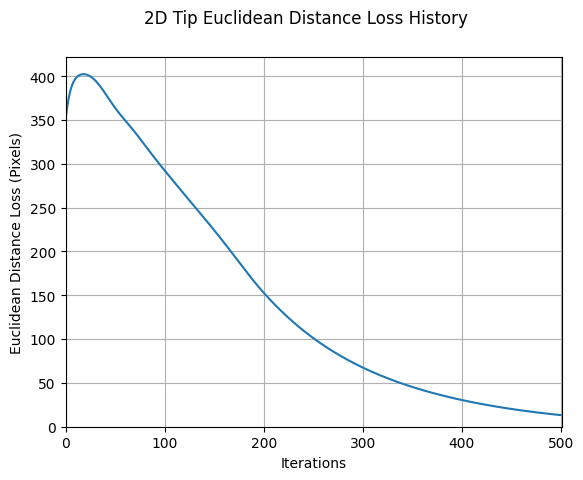

d3d_end_effector_loss_history:  [0.374146044254303, 0.36960527300834656, 0.36578863859176636, 0.36256393790245056, 0.35982152819633484, 0.35747745633125305, 0.3554670810699463, 0.3537397086620331, 0.3522545099258423, 0.3509776294231415, 0.3498803675174713, 0.34893763065338135, 0.3481270372867584, 0.3474280834197998, 0.346822053194046, 0.3462912440299988, 0.3458192050457001, 0.34539034962654114, 0.3449900448322296, 0.3446047008037567, 0.3442218601703644, 0.34383004903793335, 0.3434191644191742, 0.34298041462898254, 0.3425062894821167, 0.3419908285140991, 0.3414294421672821, 0.3408188223838806, 0.34015706181526184, 0.3394433259963989, 0.3386777937412262, 0.33786168694496155, 0.33699682354927063, 0.336085706949234, 0.33513143658638, 0.33413755893707275, 0.33310800790786743, 0.33204716444015503, 0.3309595584869385, 0.32985013723373413, 0.32872381806373596, 0.3275856673717499, 0.32644063234329224, 0.32529351115226746, 0.32414889335632324, 0.3230108618736267, 0.32188302278518677, 0.320768535

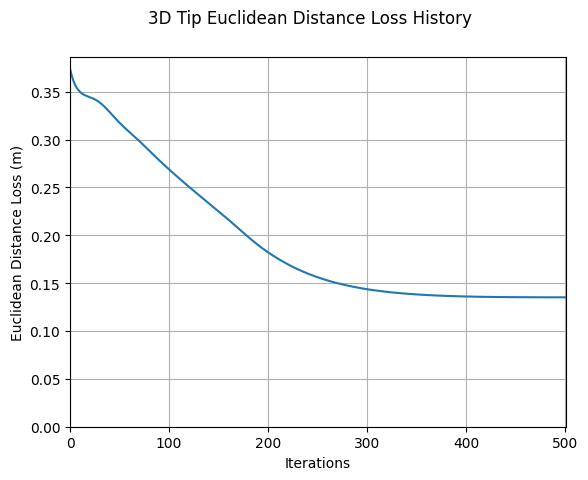

In [12]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.set_ylim(bottom=0)
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
ax2.set_ylim(bottom=0)
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()

In [13]:
p_start_np = p_start.numpy()
print(p_start_np)
result = catheter_optimize_model.para_init.data.cpu().numpy()
print("result: ", result)
control_points = np.vstack([p_start_np, result.reshape(2, 3)])
print("control_points: ", control_points)
control_points_gt = np.vstack([p_start_np, para_gt_np.reshape(2, 3)])
control_points_init = np.vstack([p_start_np, para_init.reshape(2, 3)])

[2.e-02 2.e-03 1.e-06]
result:  [ 0.06848744 -0.08988798  0.4396048   0.13991416 -0.21871476  0.81787235]
control_points:  [[ 2.0000000e-02  2.0000001e-03  1.0000000e-06]
 [ 6.8487443e-02 -8.9887977e-02  4.3960479e-01]
 [ 1.3991416e-01 -2.1871476e-01  8.1787235e-01]]


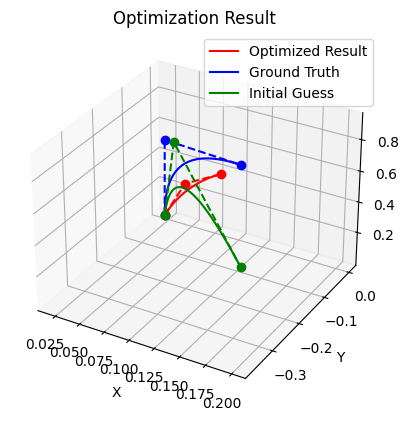

In [14]:
def bezier_curve_3d(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 3))

    for i in range(num_points):
        curve[i] = (1 - t[i]) ** 2 * control_points[0] + \
                   2 * (1 - t[i]) * t[i] * control_points[1] + \
                   t[i] ** 2 * control_points[2]

    return curve

# Generate the Bezier curve
curve = bezier_curve_3d(control_points)
curve_gt = bezier_curve_3d(control_points_gt)
curve_init = bezier_curve_3d(control_points_init)

# Plotting the Bezier curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制第一条贝塞尔曲线及其控制点
ax.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'ro--')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], 'r-', label='Optimized Result')

# 绘制第二条贝塞尔曲线及其控制点
ax.plot(control_points_gt[:, 0], control_points_gt[:, 1], control_points_gt[:, 2], 'bo--')
ax.plot(curve_gt[:, 0], curve_gt[:, 1], curve_gt[:, 2], 'b-', label='Ground Truth')

ax.plot(control_points_init[:, 0], control_points_init[:, 1], control_points_init[:, 2], 'go--')
ax.plot(curve_init[:, 0], curve_init[:, 1], curve_init[:, 2], 'g-', label='Initial Guess')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Optimization Result')
ax.legend()

plt.savefig('Result.png')

plt.show()